This notebook is the continuation of the previous notebook 'TS classification-1'. Please refer the previous notebook for continuity.<br><br>

Notes:<br>
-In this notebook, we implement time series classification on a larger and more complex dataset.<br>
-However, we tackle a supervised learning problem in the notebook, as opposed to unsupervised learning in the previous notebook.<br>
-To recognize and use much more complex features we use neural networks.<br>




In [6]:
import numpy as np  # For ease of performing mathematical operations with arrays
import torch  # For working with tensors
import torch.nn as nn  # For building different layers of the neural network
import torch.nn.functional as F  # For performing different functions relating to the neural network
import torch.optim as optim # For getting optimizers
import matplotlib.pyplot as plt # For plotting
from torch.utils.data import DataLoader, TensorDataset  # For efficient batching and building a iterable wrapper around input elemets.

In [7]:
# Reading the dataset
def readucr(file):
  data = np.loadtxt(file, delimiter="\t")
  y = data[:, 0]
  x = data[:, 1:]
  return x, y.astype(int)

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")


<Figure size 640x480 with 0 Axes>

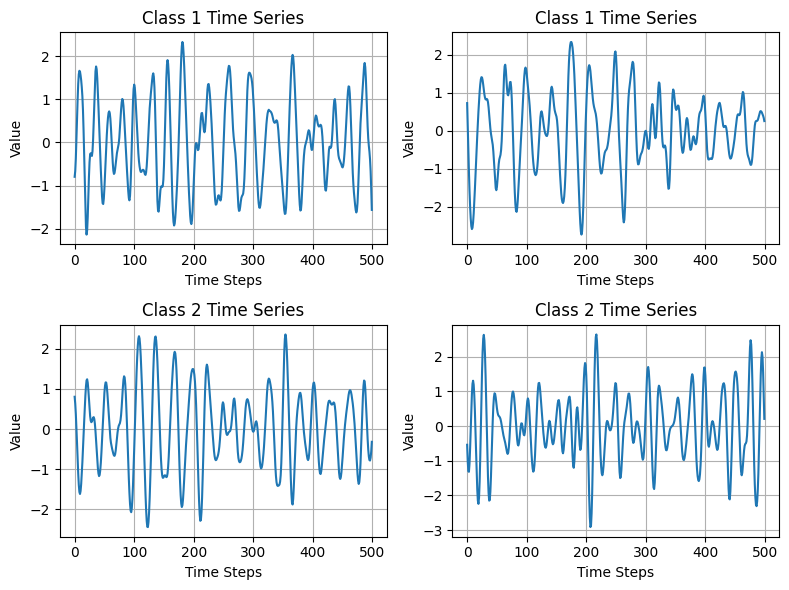

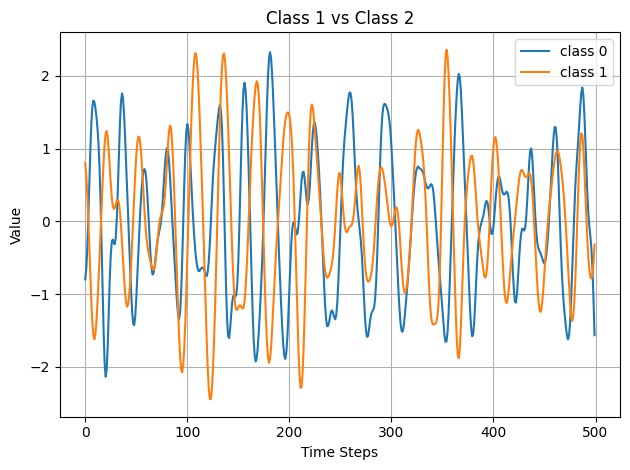

In [14]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
c_x_train = []
for c in classes:
  c_x_train.append(x_train[y_train == c])

_, ax = plt.subplots(2, 2, figsize = (8,6))
for i in range(2):
  for j in range(2):
    ax[i, j].plot(c_x_train[i][j])
    ax[i, j].set_title(f'Class {i+1} Time Series')
    ax[i, j].set_xlabel('Time Steps')
    ax[i, j].set_ylabel('Value')
    ax[i, j].grid()

plt.tight_layout()
plt.show()
plt.plot(c_x_train[0][0], label="class " + str(0))
plt.plot(c_x_train[1][0], label="class " + str(1))
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Class 1 vs Class 2')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

Reshaping necessary as conv layers in pytorch expect data in the (batch_size, sequence_length, num_channels).<br>
In our case, the num_channels is 1 as we are working with time series data

In [15]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [16]:
num_classes = len(np.unique(y_train)) # Getting the number of class labels in the test set

Shuffling the input dataset to get a random order

In [17]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [18]:
y_train[y_train == -1] = 0  # Changing the label -1 to 0 for ease of computation
y_test[y_test == -1] = 0

###Model:

-Initially a simple neural network with only linear layers, activation functions and softmax layer was built.<br>
-The performance of this model was not good.<br>
-A model with convolutional layers was then build which had much better functionality.<br>
-This can be attributed to the lack of ability of fully connected linear layers to learn local level.

Notes:<br>
-Networks like RNN and LSTM with residual connections would provide better results in problems like this.<br>
-This would be a scope for future expansion of this work.


In [19]:
class NeuralNet(nn.Module):
  def __init__(self, input_shape, num_classes):
    super(NeuralNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=input_shape[0], out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU()
    )
    self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU()
    )
    self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
    self.fc = nn.Linear(64, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.global_avg_pool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

# Prepare the data
def prepare_data(x_train, y_train, batch_size=32):
  dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
  train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return train_loader

# Training parameters
epochs = 50
batch_size = 32
lr = 0.001
patience = 30
min_lr = 0.0001
reduce_lr_factor = 0.5

# Initialize the model, optimizer, and loss function
model = NeuralNet(input_shape=(x_train.shape[1], x_train.shape[2]), num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=reduce_lr_factor, patience=20, min_lr=min_lr)

# Prepare data loaders
train_loader = prepare_data(x_train, y_train, batch_size)
val_loader = prepare_data(x_test, y_test, batch_size)  # Assuming you have validation split

# Training loop
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    # Print progress
    print(f'Epoch {epoch+1}/{epochs} - '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

print('Training complete')


Epoch 1/50 - Train Loss: 0.6182, Train Accuracy: 66.18% - Val Loss: 0.5947, Val Accuracy: 69.02%
Epoch 2/50 - Train Loss: 0.5329, Train Accuracy: 73.37% - Val Loss: 0.5809, Val Accuracy: 69.32%
Epoch 3/50 - Train Loss: 0.4690, Train Accuracy: 77.90% - Val Loss: 0.5634, Val Accuracy: 72.80%
Epoch 4/50 - Train Loss: 0.4092, Train Accuracy: 81.14% - Val Loss: 0.5612, Val Accuracy: 73.26%
Epoch 5/50 - Train Loss: 0.3813, Train Accuracy: 83.06% - Val Loss: 0.5387, Val Accuracy: 74.17%
Epoch 6/50 - Train Loss: 0.3296, Train Accuracy: 86.23% - Val Loss: 0.5157, Val Accuracy: 75.76%
Epoch 7/50 - Train Loss: 0.2939, Train Accuracy: 87.81% - Val Loss: 0.5629, Val Accuracy: 74.70%
Epoch 8/50 - Train Loss: 0.2793, Train Accuracy: 88.34% - Val Loss: 0.5767, Val Accuracy: 75.08%
Epoch 9/50 - Train Loss: 0.2625, Train Accuracy: 89.28% - Val Loss: 0.5895, Val Accuracy: 75.53%
Epoch 10/50 - Train Loss: 0.2395, Train Accuracy: 90.45% - Val Loss: 0.6122, Val Accuracy: 75.91%
Epoch 11/50 - Train Loss: 0.2